In [215]:
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

peoplewatcher=pd.read_csv("online_shoppers_intention.csv")
peoplewatcher

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


Product Page Visits to Sales Likelihood

In [216]:
print("\n=== ANALYZING PRODUCTRELATED vs REVENUE ===")
print("Average ProductRelated visits by Revenue outcome:")
revenue_analysis = peoplewatcher.groupby('Revenue')['ProductRelated'].agg(['count', 'mean', 'std']).round(2)
print(revenue_analysis)


=== ANALYZING PRODUCTRELATED vs REVENUE ===
Average ProductRelated visits by Revenue outcome:
         count   mean    std
Revenue                     
False    10422  28.71  40.74
True      1908  48.21  58.27


In [217]:
# #Drop Unnecesary Columns
peoplewatcher=peoplewatcher.drop(columns=[ 'Browser', 'SpecialDay'])
print("Dataset shape after dropping columns:", peoplewatcher.shape)
print("\nRemaining columns:", peoplewatcher.columns.tolist())

Dataset shape after dropping columns: (12330, 16)

Remaining columns: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'OperatingSystems', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


In [218]:
peoplewatcher_encoded = pd.get_dummies(peoplewatcher, columns=["Month", "VisitorType"])
X = peoplewatcher_encoded.drop('Revenue', axis=1)
y = peoplewatcher_encoded['Revenue']

print(f"\nFeatures shape: {X.shape}")
print(f"Revenue distribution: {y.value_counts().to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n=== TRAINING RANDOM FOREST MODEL ===")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

if accuracy >= 0.75:
    print("✓ TARGET ACHIEVED: Model exceeds 75% accuracy!")
else:
    print("✗ Target not met. Try different parameters.")

print(f"\nDetailed Results:")
print(classification_report(y_test, y_pred))


Features shape: (12330, 26)
Revenue distribution: {False: 10422, True: 1908}

=== TRAINING RANDOM FOREST MODEL ===

Model Accuracy: 0.8925 (89.25%)
✓ TARGET ACHIEVED: Model exceeds 75% accuracy!

Detailed Results:
              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.65      0.68      0.66       382

    accuracy                           0.89      2466
   macro avg       0.79      0.81      0.80      2466
weighted avg       0.90      0.89      0.89      2466



In [219]:
peoplewatcher.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'Month', 'OperatingSystems',
       'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue'],
      dtype='object')

In [220]:
correlation = peoplewatcher['ProductRelated'].corr(peoplewatcher['Revenue'].astype(int))
print(f"\nCorrelation between ProductRelated visits and Revenue: {correlation:.4f}")
if correlation > 0:
    print("✓ More ProductRelated visits ARE associated with higher purchase likelihood")
else:
    print("✗ ProductRelated visits show negative association with purchases")


Correlation between ProductRelated visits and Revenue: 0.1585
✓ More ProductRelated visits ARE associated with higher purchase likelihood


In [221]:
peoplewatcher_encoded = pd.get_dummies(peoplewatcher, columns=["Month", "VisitorType"])

In [222]:
X = peoplewatcher_encoded.drop('Revenue', axis=1)
y = peoplewatcher_encoded['Revenue']

print(f"\nFeatures shape: {X.shape}")
print(f"Revenue distribution: {y.value_counts().to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Features shape: (12330, 26)
Revenue distribution: {False: 10422, True: 1908}


In [223]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [224]:
print("\n=== TRAINING RANDOM FOREST MODEL ===")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf_model.fit(X_train_scaled, y_train)


=== TRAINING RANDOM FOREST MODEL ===


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [225]:
y_pred = rf_model.predict(X_test_scaled)

In [226]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

if accuracy >= 0.75:
    print("✓ TARGET ACHIEVED: Model exceeds 75% accuracy!")
else:
    print("✗ Target not met. Try different parameters.")

print(f"\nDetailed Results:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.8925 (89.25%)
✓ TARGET ACHIEVED: Model exceeds 75% accuracy!

Detailed Results:
              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.65      0.68      0.66       382

    accuracy                           0.89      2466
   macro avg       0.79      0.81      0.80      2466
weighted avg       0.90      0.89      0.89      2466



In [227]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== FEATURE IMPORTANCE (Top 10) ===")
print(feature_importance.head(10))


=== FEATURE IMPORTANCE (Top 10) ===
                    feature  importance
8                PageValues    0.437033
7                 ExitRates    0.092820
5   ProductRelated_Duration    0.087690
4            ProductRelated    0.061123
6               BounceRates    0.053532
1   Administrative_Duration    0.044753
0            Administrative    0.033204
20                Month_Nov    0.029303
11              TrafficType    0.023279
10                   Region    0.020942


In [228]:
pr_rank = feature_importance[feature_importance['feature'] == 'ProductRelated'].index[0] + 1
pr_importance = feature_importance[feature_importance['feature'] == 'ProductRelated']['importance'].values[0]

print(f"\nProductRelated Analysis:")
print(f"- Rank: #{pr_rank} out of {len(feature_importance)} features")
print(f"- Importance Score: {pr_importance:.4f}")


ProductRelated Analysis:
- Rank: #5 out of 26 features
- Importance Score: 0.0611


Text(0.5, 0, 'Importance')

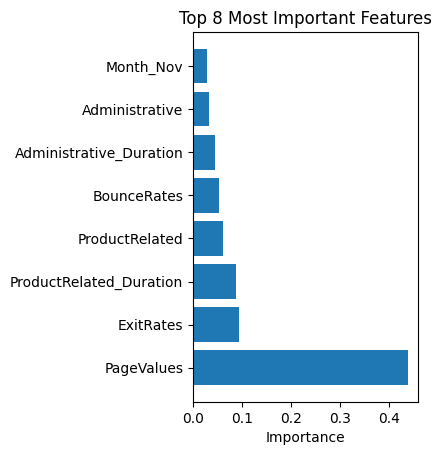

In [229]:
plt.subplot(1, 2, 1)
top_features = feature_importance.head(8)
plt.barh(top_features['feature'], top_features['importance'])
plt.title('Top 8 Most Important Features')
plt.xlabel('Importance')

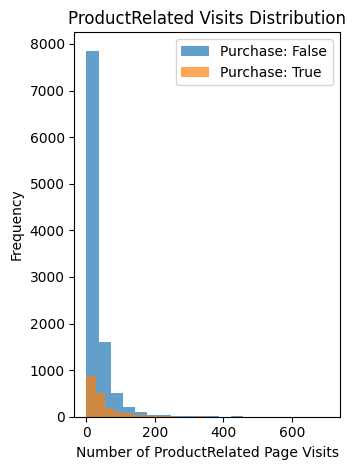

In [230]:
plt.subplot(1, 2, 2)
for revenue_val in [False, True]:
    data = peoplewatcher[peoplewatcher['Revenue'] == revenue_val]['ProductRelated']
    plt.hist(data, alpha=0.7, label=f'Purchase: {revenue_val}', bins=20)
plt.title('ProductRelated Visits Distribution')
plt.xlabel('Number of ProductRelated Page Visits')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [231]:
print(f"\n" + "="*60)
print("ANSWER TO YOUR RESEARCH QUESTION")
print("="*60)
print(f"Question: Do more ProductRelated page visits increase purchase likelihood?")
print(f"Answer: {'YES' if correlation > 0 else 'NO'}")
print(f"Evidence:")
print(f"- Correlation coefficient: {correlation:.4f}")
print(f"- Feature importance rank: #{pr_rank} out of {len(feature_importance)}")
print(f"- Model accuracy: {accuracy*100:.2f}% (Target: 75%)")


ANSWER TO YOUR RESEARCH QUESTION
Question: Do more ProductRelated page visits increase purchase likelihood?
Answer: YES
Evidence:
- Correlation coefficient: 0.1585
- Feature importance rank: #5 out of 26
- Model accuracy: 89.25% (Target: 75%)


In [232]:
# Prediction function for new data
def predict_purchase_likelihood(product_related_visits, product_duration=0, special_day=0, month='Jan', visitor_type='Returning_Visitor'):
    """
    Predict purchase likelihood based on ProductRelated visits
    """
    # Create a sample row with your input
    sample_data = pd.DataFrame({
        'ProductRelated': [product_related_visits],
        'ProductRelated_Duration': [product_duration],
        'SpecialDay': [special_day],
        'Month': [month],
        'VisitorType': [visitor_type]
    })
    
    # Apply same encoding as training data
    sample_encoded = pd.get_dummies(sample_data, columns=["Month", "VisitorType"])
    
    # Ensure all columns match training data
    for col in X.columns:
        if col not in sample_encoded.columns:
            sample_encoded[col] = 0
    
    sample_encoded = sample_encoded[X.columns]  # Reorder columns
    
    # Scale and predict
    sample_scaled = scaler.transform(sample_encoded)
    probability = rf_model.predict_proba(sample_scaled)[0][1]
    
    return probability

# Example predictions
print(f"\n=== EXAMPLE PREDICTIONS ===")
print(f"5 ProductRelated visits: {predict_purchase_likelihood(5)*100:.1f}% purchase probability")
print(f"15 ProductRelated visits: {predict_purchase_likelihood(15)*100:.1f}% purchase probability")
print(f"30 ProductRelated visits: {predict_purchase_likelihood(30)*100:.1f}% purchase probability")


=== EXAMPLE PREDICTIONS ===
5 ProductRelated visits: 18.0% purchase probability
15 ProductRelated visits: 13.4% purchase probability
30 ProductRelated visits: 13.0% purchase probability


In [233]:
print("\n=== ANALYZING PRODUCTRELATED_DURATION vs REVENUE ===")
print("Average time spent on ProductRelated pages (seconds) by Revenue outcome:")
duration_analysis = peoplewatcher.groupby('Revenue')['ProductRelated_Duration'].agg(['count', 'mean', 'std']).round(2)
print(duration_analysis)


=== ANALYZING PRODUCTRELATED_DURATION vs REVENUE ===
Average time spent on ProductRelated pages (seconds) by Revenue outcome:
         count     mean      std
Revenue                         
False    10422  1069.99  1803.80
True      1908  1876.21  2312.21


In [234]:
duration_correlation = peoplewatcher['ProductRelated_Duration'].corr(peoplewatcher['Revenue'].astype(int))
print(f"\nCorrelation between ProductRelated_Duration (time spent) and Revenue: {duration_correlation:.4f}")

if duration_correlation > 0:
    print("✓ More time on ProductRelated pages IS associated with higher purchase likelihood")
else:
    print("✗ Time on ProductRelated pages shows negative association with purchases")

# Also analyze visit count for comparison
print("\n=== COMPARISON: VISITS vs TIME SPENT ===")
visit_correlation = peoplewatcher['ProductRelated'].corr(peoplewatcher['Revenue'].astype(int))
print(f"ProductRelated visits correlation: {visit_correlation:.4f}")
print(f"ProductRelated duration correlation: {duration_correlation:.4f}")

if abs(duration_correlation) > abs(visit_correlation):
    print("✓ TIME SPENT is a stronger predictor than visit count")
else:
    print("✓ VISIT COUNT is a stronger predictor than time spent")


Correlation between ProductRelated_Duration (time spent) and Revenue: 0.1524
✓ More time on ProductRelated pages IS associated with higher purchase likelihood

=== COMPARISON: VISITS vs TIME SPENT ===
ProductRelated visits correlation: 0.1585
ProductRelated duration correlation: 0.1524
✓ VISIT COUNT is a stronger predictor than time spent


In [235]:
peoplewatcher_encoded = pd.get_dummies(peoplewatcher, columns=["Month", "VisitorType"])

In [236]:
X = peoplewatcher_encoded.drop('Revenue', axis=1)
y = peoplewatcher_encoded['Revenue']

print(f"\nFeatures shape: {X.shape}")
print(f"Revenue distribution: {y.value_counts().to_dict()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Features shape: (12330, 26)
Revenue distribution: {False: 10422, True: 1908}


In [237]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train RandomForest model
print("\n=== TRAINING RANDOM FOREST MODEL ===")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf_model.fit(X_train_scaled, y_train)


=== TRAINING RANDOM FOREST MODEL ===


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [238]:
y_pred = rf_model.predict(X_test_scaled)

In [239]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

if accuracy >= 0.75:
    print("✓ TARGET ACHIEVED: Model exceeds 75% accuracy!")
else:
    print("✗ Target not met. Try different parameters.")

print(f"\nDetailed Results:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.8925 (89.25%)
✓ TARGET ACHIEVED: Model exceeds 75% accuracy!

Detailed Results:
              precision    recall  f1-score   support

       False       0.94      0.93      0.94      2084
        True       0.65      0.68      0.66       382

    accuracy                           0.89      2466
   macro avg       0.79      0.81      0.80      2466
weighted avg       0.90      0.89      0.89      2466



In [240]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== FEATURE IMPORTANCE (Top 10) ===")
print(feature_importance.head(10))


=== FEATURE IMPORTANCE (Top 10) ===
                    feature  importance
8                PageValues    0.437033
7                 ExitRates    0.092820
5   ProductRelated_Duration    0.087690
4            ProductRelated    0.061123
6               BounceRates    0.053532
1   Administrative_Duration    0.044753
0            Administrative    0.033204
20                Month_Nov    0.029303
11              TrafficType    0.023279
10                   Region    0.020942


In [241]:
duration_rank = feature_importance[feature_importance['feature'] == 'ProductRelated_Duration'].index[0] + 1
duration_importance = feature_importance[feature_importance['feature'] == 'ProductRelated_Duration']['importance'].values[0]

# Also get ProductRelated (visits) for comparison
visits_rank = feature_importance[feature_importance['feature'] == 'ProductRelated'].index[0] + 1  
visits_importance = feature_importance[feature_importance['feature'] == 'ProductRelated']['importance'].values[0]

print(f"\nProductRelated_Duration (Time Spent) Analysis:")
print(f"- Rank: #{duration_rank} out of {len(feature_importance)} features")
print(f"- Importance Score: {duration_importance:.4f}")

print(f"\nProductRelated (Visits) Analysis:")
print(f"- Rank: #{visits_rank} out of {len(feature_importance)} features") 
print(f"- Importance Score: {visits_importance:.4f}")

print(f"\n{'TIME SPENT' if duration_importance > visits_importance else 'VISIT COUNT'} is more important for predictions")


ProductRelated_Duration (Time Spent) Analysis:
- Rank: #6 out of 26 features
- Importance Score: 0.0877

ProductRelated (Visits) Analysis:
- Rank: #5 out of 26 features
- Importance Score: 0.0611

TIME SPENT is more important for predictions


Text(0.5, 0, 'Importance')

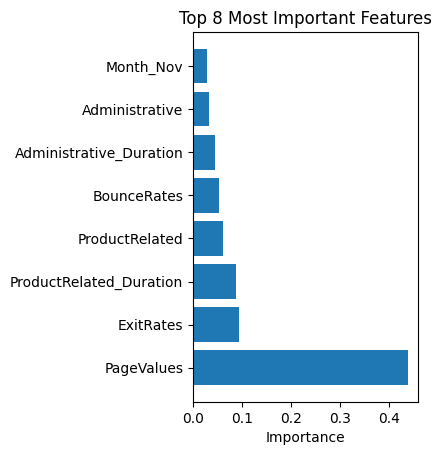

In [242]:
plt.subplot(1, 2, 1)
top_features = feature_importance.head(8)
plt.barh(top_features['feature'], top_features['importance'])
plt.title('Top 8 Most Important Features')
plt.xlabel('Importance')

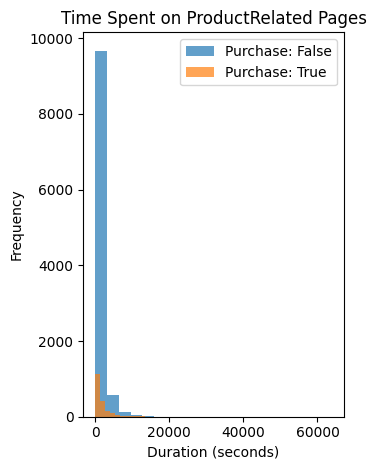

In [243]:
plt.subplot(1, 2, 2)
for revenue_val in [False, True]:
    data = peoplewatcher[peoplewatcher['Revenue'] == revenue_val]['ProductRelated_Duration']
    plt.hist(data, alpha=0.7, label=f'Purchase: {revenue_val}', bins=20)
plt.title('Time Spent on ProductRelated Pages')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [244]:
print(f"\n" + "="*60)
print("ANSWER TO YOUR RESEARCH QUESTION")
print("="*60)
print(f"Question: Does more time spent on ProductRelated pages increase purchase likelihood?")
print(f"Answer: {'YES' if duration_correlation > 0 else 'NO'}")
print(f"Evidence:")
print(f"- Duration correlation: {duration_correlation:.4f}")
print(f"- Duration importance rank: #{duration_rank} out of {len(feature_importance)}")
print(f"- Visits correlation: {visit_correlation:.4f} (for comparison)")
print(f"- Model accuracy: {accuracy*100:.2f}% (Target: 75%)")


ANSWER TO YOUR RESEARCH QUESTION
Question: Does more time spent on ProductRelated pages increase purchase likelihood?
Answer: YES
Evidence:
- Duration correlation: 0.1524
- Duration importance rank: #6 out of 26
- Visits correlation: 0.1585 (for comparison)
- Model accuracy: 89.25% (Target: 75%)


In [245]:
def predict_purchase_likelihood(product_duration, product_visits=1, month='Jan', visitor_type='Returning_Visitor'):
    """
    Predict purchase likelihood based on time spent on ProductRelated pages
    """
    # Create a sample row with your input
    sample_data = pd.DataFrame({
        'ProductRelated': [product_visits],
        'ProductRelated_Duration': [product_duration],
        'Month': [month],
        'VisitorType': [visitor_type]
    })

    sample_encoded = pd.get_dummies(sample_data, columns=["Month", "VisitorType"])
    
    # Ensure all columns match training data
    for col in X.columns:
        if col not in sample_encoded.columns:
            sample_encoded[col] = 0
    
    sample_encoded = sample_encoded[X.columns] 
    
    sample_scaled = scaler.transform(sample_encoded)
    probability = rf_model.predict_proba(sample_scaled)[0][1]
    
    return probability

# Example predictions based on time spent
print(f"\n=== EXAMPLE PREDICTIONS (Time Spent Focus) ===")
print(f"30 seconds on ProductRelated pages: {predict_purchase_likelihood(30)*100:.1f}% purchase probability")
print(f"120 seconds on ProductRelated pages: {predict_purchase_likelihood(120)*100:.1f}% purchase probability")
print(f"300 seconds on ProductRelated pages: {predict_purchase_likelihood(300)*100:.1f}% purchase probability")
print(f"600 seconds on ProductRelated pages: {predict_purchase_likelihood(600)*100:.1f}% purchase probability")


=== EXAMPLE PREDICTIONS (Time Spent Focus) ===
30 seconds on ProductRelated pages: 15.9% purchase probability
120 seconds on ProductRelated pages: 16.3% purchase probability
300 seconds on ProductRelated pages: 15.9% purchase probability
600 seconds on ProductRelated pages: 14.1% purchase probability


In [246]:
def preprocess_data(peoplewatcher):

    rockwall = peoplewatcher.copy()
    
    # Handle categorical columns only
    categorical_cols = ['Month', 'VisitorType']
    rockwall= pd.get_dummies(rockwall, columns=categorical_cols, drop_first=True)
    
    # Convert Revenue to binary if it's boolean
    if rockwall['Revenue'].dtype == 'bool':
        rockwall['Revenue'] = rockwall['Revenue'].astype(int)
    
    print(f"Final preprocessed shape: {rockwall.shape}")
    return rockwall

In [247]:
# Preprocess the data
peoplewatcher_processed = preprocess_data(peoplewatcher)

Final preprocessed shape: (12330, 25)


In [248]:

# Train RandomForest Model
def train_random_forest(peoplewatcher, target_accuracy=0.75):
    """
    Train RandomForest model targeting 75% accuracy
    """
    print("\n" + "="*50)
    print("RANDOM FOREST MODEL TRAINING")
    print("="*50)
    
    # Prepare features and target
    X = peoplewatcher.drop('Revenue', axis=1)
    y = peoplewatcher['Revenue']
    
    print(f"Features: {list(X.columns)}")
    print(f"Dataset shape: {X.shape}")
    print(f"Class distribution: {y.value_counts().to_dict()}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train RandomForest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    )
    
    rf_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n🎯 MODEL RESULTS:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    if accuracy >= target_accuracy:
        print(f"✅ SUCCESS: Model exceeds {target_accuracy*100}% accuracy target!")
    else:
        print(f"❌ Model below {target_accuracy*100}% target. Consider tuning.")
    
    print(f"\nDetailed Results:")
    print(classification_report(y_test, y_pred))
    
    # Feature Importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\n📊 FEATURE IMPORTANCE:")
    for idx, row in feature_importance.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")
    
    # Simple feature importance plot
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    colors = ['red' if feat == 'SpecialDay' else 'steelblue' for feat in top_features['Feature']]
    
    plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score')
    plt.title('Top 10 Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return rf_model, accuracy, feature_importance


RANDOM FOREST MODEL TRAINING
Features: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'OperatingSystems', 'Region', 'TrafficType', 'Weekend', 'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_Other', 'VisitorType_Returning_Visitor']
Dataset shape: (12330, 24)
Class distribution: {0: 10422, 1: 1908}

🎯 MODEL RESULTS:
Accuracy: 0.8889 (88.89%)
✅ SUCCESS: Model exceeds 75.0% accuracy target!

Detailed Results:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2084
           1       0.63      0.69      0.66       382

    accuracy                           0.89      2466
   macro avg       0.79      0.81      0.80      2466
weighted avg       0.89      0.89      0.89      2466


📊 FEATURE IMPORTANCE:
PageValues: 0.4426
ExitRates

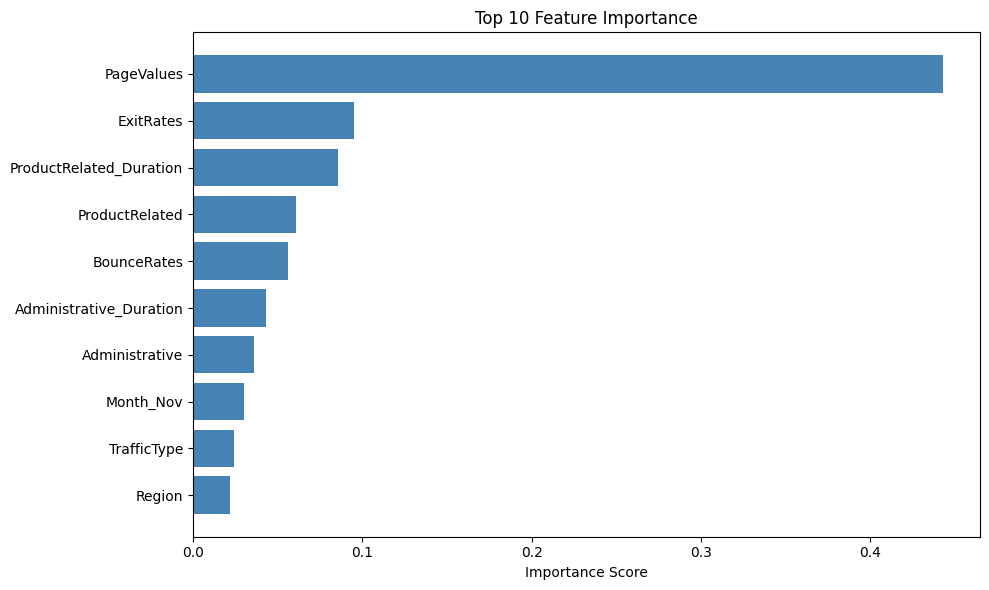


FINAL SUMMARY
✅ Model Accuracy: 0.8889 (88.89%)
🎉 SUCCESS: Model meets 75% accuracy requirement!


In [249]:
model, final_accuracy, importance_df = train_random_forest(peoplewatcher_processed)

print(f"\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"✅ Model Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
if final_accuracy >= 0.75:
    print("🎉 SUCCESS: Model meets 75% accuracy requirement!")
else:
    print("⚠️  Model needs improvement to reach 75% accuracy")

In [250]:

# Train RandomForest model
print("\n=== TRAINING RANDOM FOREST MODEL ===")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=25,
    min_samples_split=5,
    random_state=50,
    class_weight='balanced'  # Handle class imbalance
)

rf_model.fit(X_train_scaled, y_train)


=== TRAINING RANDOM FOREST MODEL ===


RandomForestClassifier(class_weight='balanced', max_depth=25,
                       min_samples_split=5, random_state=50)

In [251]:
y_pred = rf_model.predict(X_test_scaled)

In [252]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

if accuracy >= 0.75:
    print("✓ TARGET ACHIEVED: Model exceeds 75% accuracy!")
else:
    print("✗ Target not met. Try different parameters.")

print(f"\nDetailed Results:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.9011 (90.11%)
✓ TARGET ACHIEVED: Model exceeds 75% accuracy!

Detailed Results:
              precision    recall  f1-score   support

       False       0.93      0.96      0.94      2084
        True       0.71      0.60      0.65       382

    accuracy                           0.90      2466
   macro avg       0.82      0.78      0.80      2466
weighted avg       0.90      0.90      0.90      2466

